# Menghubungkan Google Drive

In [ ]:
!nvidia-smi

In [ ]:
!df -h

In [ ]:
!cat /proc/cpuinfo

In [ ]:
!cat /proc/meminfo

In [ ]:
!df -h / | awk '{print $4}'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Library

In [ ]:
!pip install tensorflow==2.15.0

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import seaborn as sns
import random
import cv2
import os
import shutil
import glob as gb
import matplotlib.pyplot as plt
from pathlib import Path
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report, f1_score, recall_score, precision_score, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, MaxPooling2D, Dropout, Conv2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler


# Memuat Data

In [ ]:
%cd /content/drive/MyDrive/archive

/content/drive/.shortcut-targets-by-id/1hrm502meOfTKXnWAZsJDS6C3RT0YmS5t/Deteksi Rupiah


In [ ]:
image_dir = Path('/content/drive/MyDrive/archive/Data_Training')

# Mendapatkan path file dan label
filepaths = list(image_dir.glob(r'**/*.*'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

file_extensions = set(path.suffix.lower() for path in filepaths)
print("Ekstensi File yang Ditemukan:", file_extensions)

filepaths = pd.Series(filepaths, name='Filepaths').astype(str)
labels = pd.Series(labels, name='Labels')

# Menggabungkan path file dengan label
images_df = pd.concat([filepaths, labels], axis=1)

# Acak data dan reset index
images_df = images_df.sample(frac=1).reset_index(drop=True)

# Menampilkan data
images_df.head()


Ekstensi File yang Ditemukan: {'.jpg'}


Filepaths Labels
0  /content/drive/MyDrive/archive/Data_Training/P...  PALSU
1  /content/drive/MyDrive/archive/Data_Training/A...   ASLI
2  /content/drive/MyDrive/archive/Data_Training/P...  PALSU
3  /content/drive/MyDrive/archive/Data_Training/P...  PALSU
4  /content/drive/MyDrive/archive/Data_Training/A...   ASLI

In [ ]:
images_df.Labels.value_counts()

Labels
PALSU    110
ASLI     110
Name: count, dtype: int64

Visualisasi

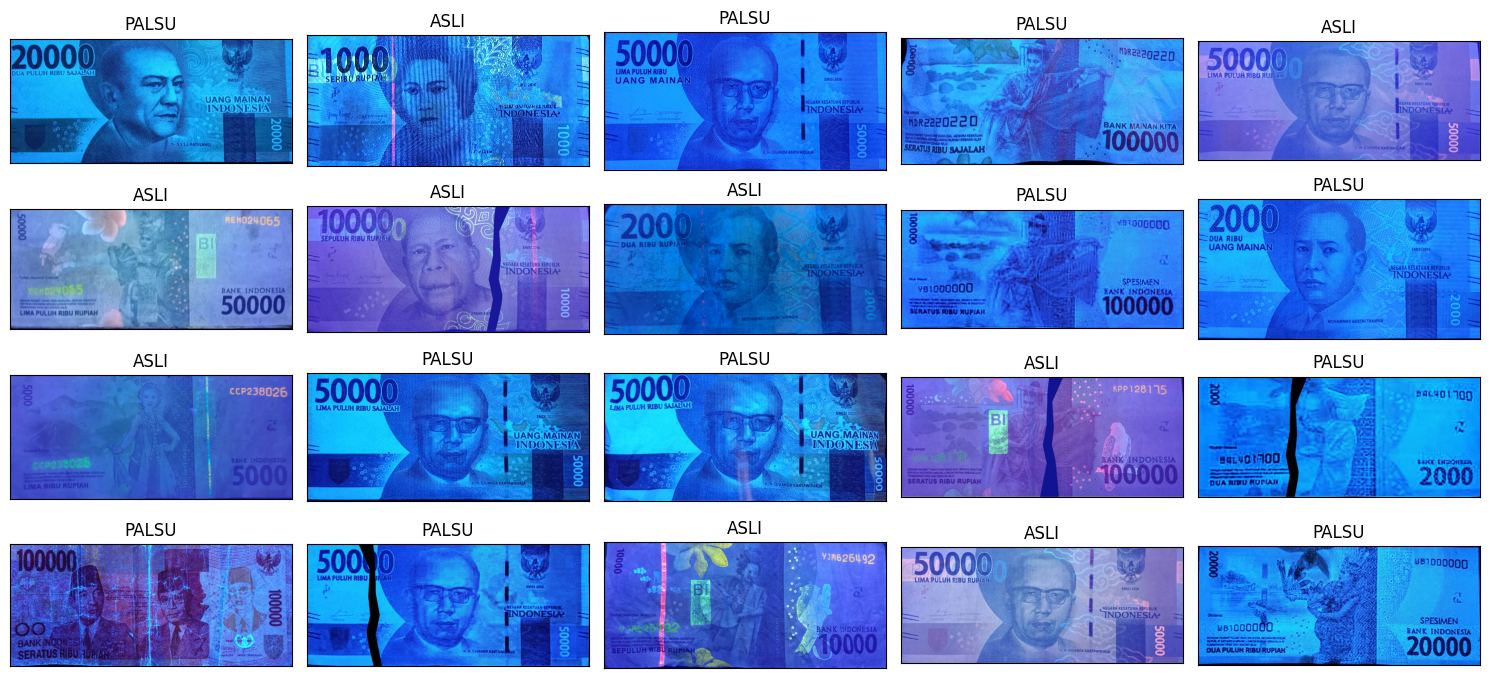

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(images_df.Filepaths[i]))
    ax.set_title(images_df.Labels[i])
plt.tight_layout()
plt.show()

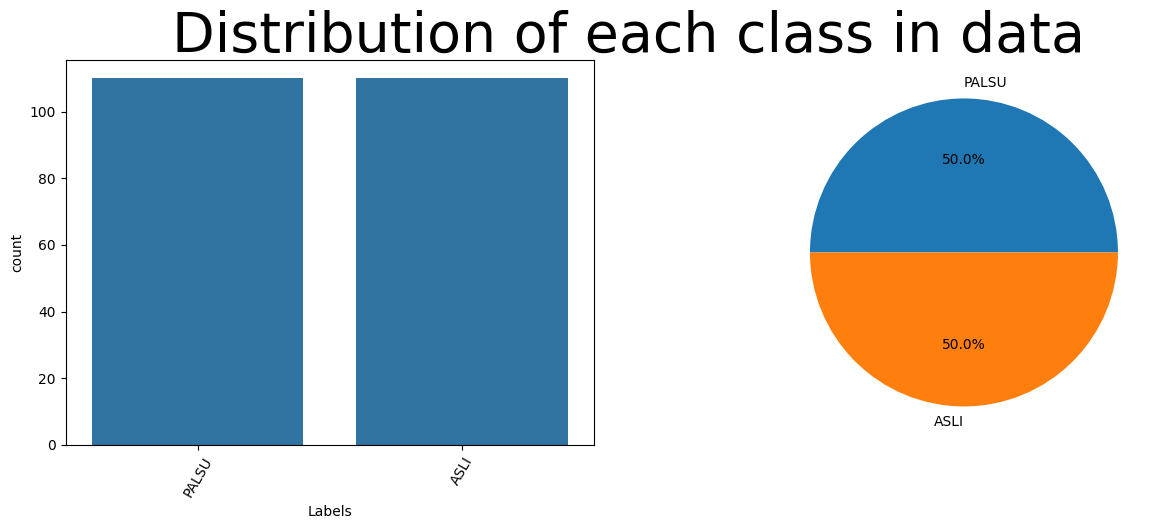

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(data=images_df,x='Labels')
plt.xticks(rotation = 60)
plt.subplot(1,2,2)
plt.pie(x = images_df['Labels'].value_counts().values, labels=images_df['Labels'].value_counts().index,autopct='%1.1f%%')
plt.suptitle('Distribution of each class in data',size=40)
plt.show()

Pembagian data

In [ ]:
train_df, test_df = train_test_split(images_df, test_size=0.2, random_state=2, shuffle=True, stratify=images_df['Labels'])
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=2, shuffle=True, stratify=test_df['Labels'])

In [ ]:
train_df.count()

Filepaths    176
Labels       176
dtype: int64

In [ ]:
val_df.count()

Filepaths    22
Labels       22
dtype: int64

In [ ]:
test_df.count()

Filepaths    22
Labels       22
dtype: int64

# Preprocessing Data

In [ ]:
# Tetapkan seed acak
seed_value = 2
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
tf.keras.utils.set_random_seed(seed_value)
tf.config.experimental.enable_op_determinism()

In [ ]:
# ImageDataGenerator untuk data pelatihan dengan augmentasi
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255  # Menambahkan rescale untuk normalisasi
)

# ImageDataGenerator untuk data validasi tanpa augmentasi
val_datagen = ImageDataGenerator(rescale=1./255)  # Menambahkan rescale untuk normalisasi

# ImageDataGenerator untuk data pengujian tanpa augmentasi
test_datagen = ImageDataGenerator(rescale=1./255)  # Menambahkan rescale untuk normalisasi

# Flow from DataFrame untuk data pelatihan
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="Filepaths",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True
)

# Flow from DataFrame untuk data validasi
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="Filepaths",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)

# Flow from DataFrame untuk data pengujian
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="Filepaths",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)

Found 176 validated image filenames belonging to 2 classes.
Found 22 validated image filenames belonging to 2 classes.
Found 22 validated image filenames belonging to 2 classes.


In [ ]:
train_generator.class_indices

{'ASLI': 0, 'PALSU': 1}

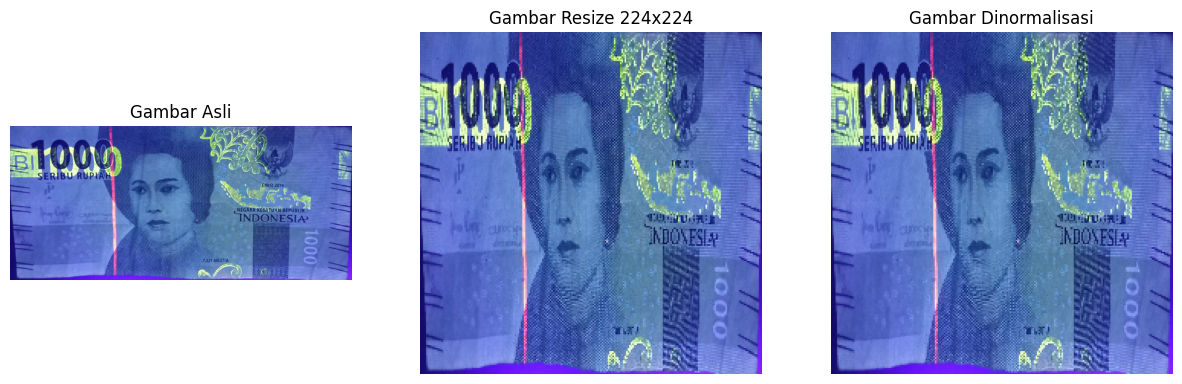

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Memuat gambar menggunakan OpenCV
image = cv2.imread('/content/drive/MyDrive/archive/Data_Training/ASLI/uang_1.jpg')

# Mengonversi dari BGR (format OpenCV) ke RGB (format matplotlib)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Mengubah ukuran gambar menjadi 224x224
image_resized = cv2.resize(image_rgb, (224, 224))

# Normalisasi gambar (mengubah nilai piksel menjadi antara 0 dan 1)
image_normalized = image_resized / 255.0

# Menampilkan gambar asli
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image_rgb)
plt.title('Gambar Asli')
plt.axis('off')

# Menampilkan gambar yang telah diubah ukurannya
plt.subplot(1, 3, 2)
plt.imshow(image_resized)
plt.title('Gambar Resize 224x224')
plt.axis('off')

# Menampilkan gambar yang telah dinormalisasi
plt.subplot(1, 3, 3)
plt.imshow(image_normalized)
plt.title('Gambar Dinormalisasi')
plt.axis('off')

plt.show()



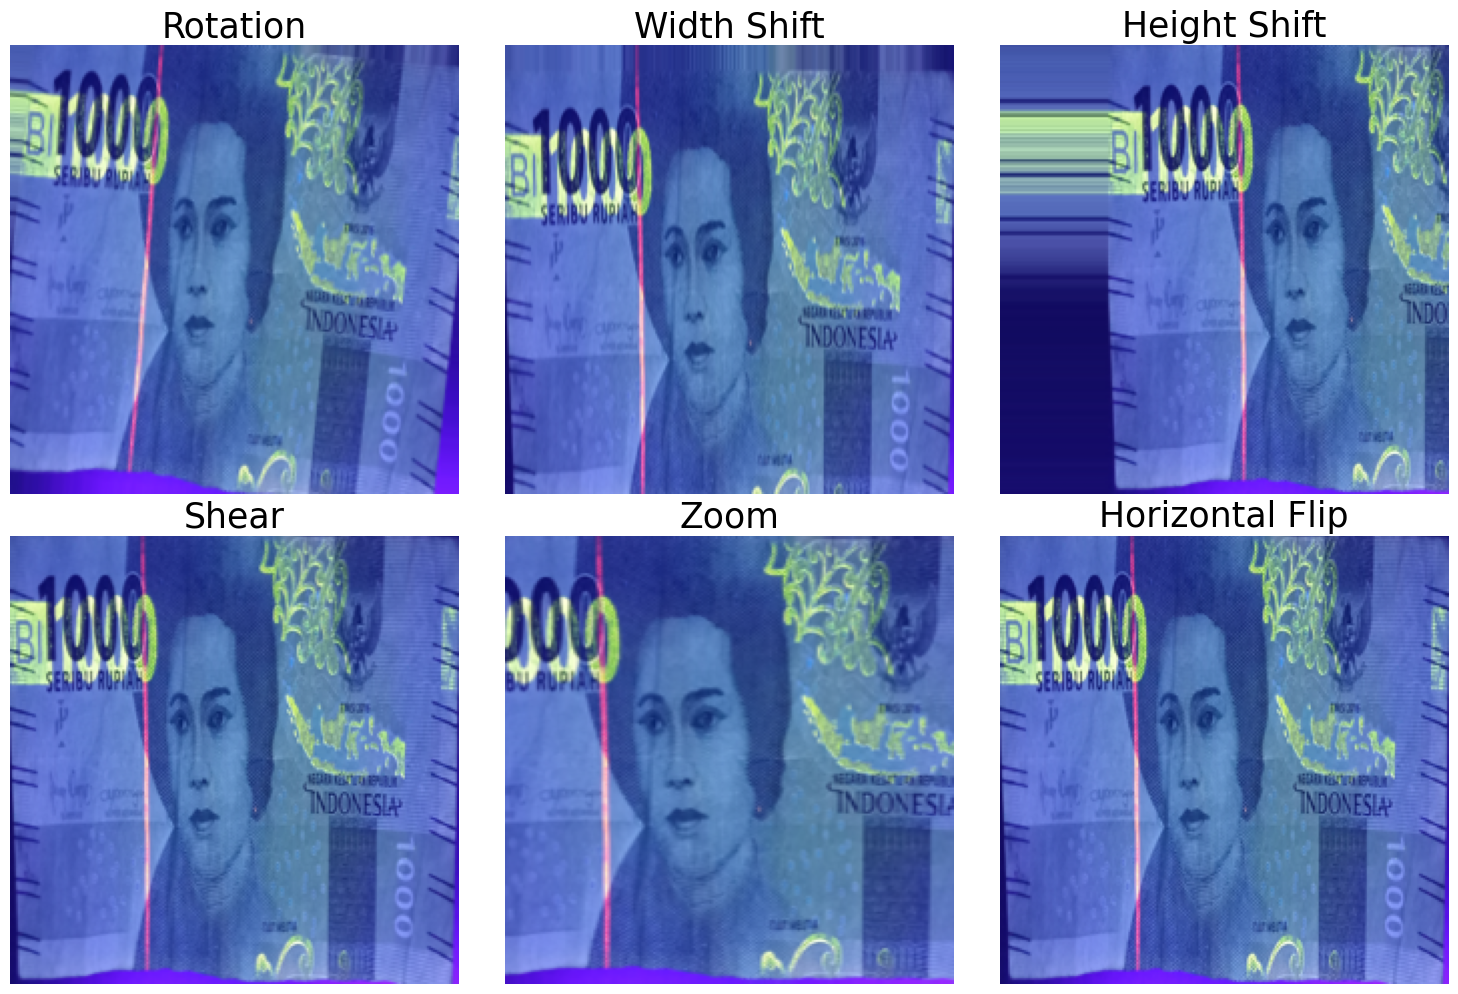

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

# Path ke gambar yang akan digunakan sebagai contoh
img_path = '/content/drive/MyDrive/archive/Data_Training/ASLI/uang_1.jpg'

# Memuat gambar dan mengubah ukurannya menjadi 224x224 piksel
img = load_img(img_path)
img_resized = img.resize((224, 224))

# Mengonversi gambar ke array NumPy dan dinormalisasi
x = img_to_array(img_resized) / 255.0
x = np.expand_dims(x, axis=0)  # Menambahkan dimensi batch

# Membuat berbagai ImageDataGenerator untuk setiap augmentasi
datagen_rotation = ImageDataGenerator(rotation_range=40)
datagen_width_shift = ImageDataGenerator(width_shift_range=0.4)
datagen_height_shift = ImageDataGenerator(height_shift_range=0.4)
datagen_shear = ImageDataGenerator(shear_range=0.4)
datagen_zoom = ImageDataGenerator(zoom_range=0.4)
datagen_flip = ImageDataGenerator(horizontal_flip=True)

# Menyimpan generator dalam daftar beserta nama augmentasinya
datagens = [
    (datagen_rotation, 'Rotation'),
    (datagen_width_shift, 'Width Shift'),
    (datagen_height_shift, 'Height Shift'),
    (datagen_shear, 'Shear'),
    (datagen_zoom, 'Zoom'),
    (datagen_flip, 'Horizontal Flip')
]

# Menampilkan contoh gambar hasil augmentasi
plt.figure(figsize=(15, 10))
for i, (datagen, aug_name) in enumerate(datagens):
    augmented_images = datagen.flow(x, batch_size=1)
    batch = next(augmented_images)  # Menggunakan `next()` untuk mendapatkan batch
    img_augmented = batch[0]

    plt.subplot(2, 3, i + 1)
    plt.imshow(img_augmented)
    plt.title(aug_name, fontsize=25)
    plt.axis('off')

plt.tight_layout()
plt.show()


# Pelatihan Model berbasis CNN MobileNet

In [ ]:
%cd /content/drive/MyDrive/archive

/content/drive/.shortcut-targets-by-id/1hrm502meOfTKXnWAZsJDS6C3RT0YmS5t/Deteksi Rupiah


In [ ]:
from tensorflow.keras.applications import MobileNetV2

# Membuat model MobileNet tanpa lapisan teratas (top layer)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Membuat model Sequential baru untuk menambahkan lapisan-lapisan kustom
model = Sequential()

# Menambahkan lapisan-lapisan MobileNet ke dalam model baru
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='sigmoid'))  # jumlah kelas, sesuaikan dengan jumlah kelas Anda

# Mematikan pelatihan lapisan-lapisan MobileNet yang sudah dilatih
for layer in base_model.layers:
    layer.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 256)               16056576  
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 18315074 (69.87 MB)
Trainable params: 16057090 (61.25 MB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


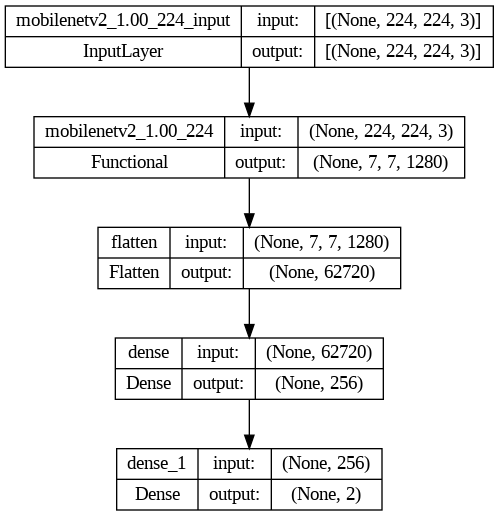

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
from tensorflow.keras.optimizers import Adam

#mengatur learning rate
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
import time

start_time = time.time()


#mengatur epoch
epoch = 30

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_generator,validation_data=val_generator, epochs=epoch, verbose=1)

end_time = time.time()
training_time = end_time - start_time
print("-----------------------")
print("Lama Waktu Training:", training_time)

Epoch 1/30
6/6 [==============================] - 88s 13s/step - loss: 1.7115 - accuracy: 0.6818 - val_loss: 0.4752 - val_accuracy: 0.8636
Epoch 2/30
6/6 [==============================] - 22s 4s/step - loss: 0.3031 - accuracy: 0.9375 - val_loss: 0.1827 - val_accuracy: 0.9091
Epoch 3/30
6/6 [==============================] - 22s 4s/step - loss: 0.0534 - accuracy: 0.9773 - val_loss: 0.0315 - val_accuracy: 1.0000
Epoch 4/30
6/6 [==============================] - 22s 4s/step - loss: 0.0621 - accuracy: 0.9716 - val_loss: 0.0635 - val_accuracy: 0.9545
Epoch 5/30
6/6 [==============================] - 21s 4s/step - loss: 0.0318 - accuracy: 0.9886 - val_loss: 0.0885 - val_accuracy: 0.9545
Epoch 6/30
6/6 [==============================] - 22s 4s/step - loss: 0.0270 - accuracy: 0.9830 - val_loss: 0.2729 - val_accuracy: 0.9091
Epoch 7/30
6/6 [==============================] - 21s 4s/step - loss: 0.0323 - accuracy: 0.9886 - val_loss: 0.1336 - val_accuracy: 0.9091
Epoch 8/30
6/6 [=================

In [ ]:
#menyimpan data hasil training
results_file = 'training epoch 30.txt'
with open(results_file, 'w') as f:
    f.write(f"Training Time: {training_time:.2f} seconds\n")
    f.write(f"Training Accuracy: {history.history['accuracy']}\n")
    f.write(f"Training Loss: {history.history['loss']}\n")
    f.write(f"Validation Accuracy: {history.history['val_accuracy']}\n")
    f.write(f"Validation Loss: {history.history['val_loss']}\n")

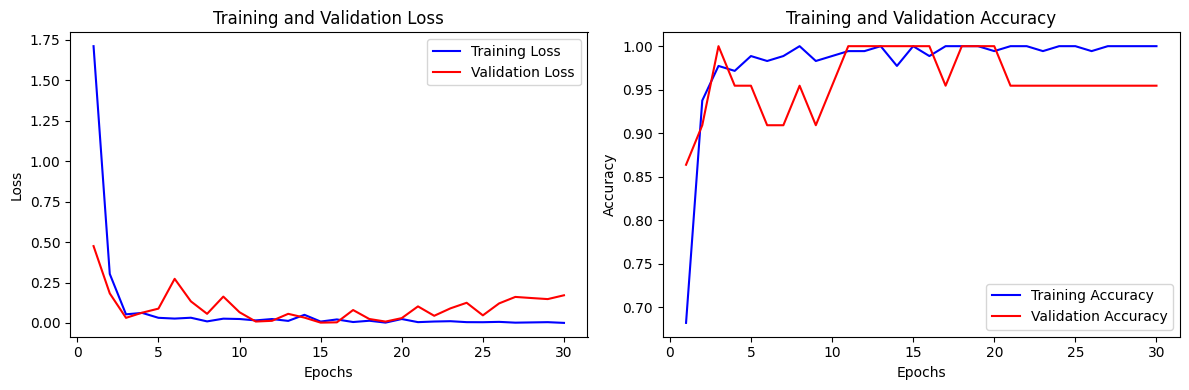

In [ ]:
# Mengambil data dari history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
epochs = range(1, len(training_loss) + 1)

# Plotting Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('train loss epoch 30.png')
plt.show()

**Testing**

In [ ]:
pred = model.predict(test_generator)
pred = np.argmax(pred, axis=1)

labels = train_generator.class_indices
labels = dict((v,k) for k, v in labels.items())

print(labels)
print(pred)

1/1 [==============================] - 2s 2s/step
{0: 'ASLI', 1: 'PALSU'}
[0 0 1 1 0 0 1 1 0 1 1 0 1 0 1 0 0 0 1 1 0 0]


In [ ]:
print(classification_report(test_generator.classes, pred, target_names=['asli', 'palsu']))
print('--------------------------------')
print(confusion_matrix(test_generator.classes, pred))
print('--------------------------------')
# Extracting F1-score, recall, precision, and accuracy
f1_value = f1_score(test_generator.classes, pred, average='weighted')
recall = recall_score(test_generator.classes, pred, average='weighted')
precision = precision_score(test_generator.classes, pred, average='weighted')
accuracy = accuracy_score(test_generator.classes, pred)


# Print with four decimal places
print(f'F1 Score: {round(f1_value, 4)}')
print(f'Recall: {round(recall, 4)}')
print(f'Precision: {round(precision, 4)}')
print(f'Accuracy: {round(accuracy, 4)}')

              precision    recall  f1-score   support

        asli       0.92      1.00      0.96        11
       palsu       1.00      0.91      0.95        11

    accuracy                           0.95        22
   macro avg       0.96      0.95      0.95        22
weighted avg       0.96      0.95      0.95        22

--------------------------------
[[11  0]
 [ 1 10]]
--------------------------------
F1 Score: 0.9545
Recall: 0.9545
Precision: 0.9583
Accuracy: 0.9545


In [ ]:
with open('evaluation results epoch 30.txt', 'w') as f:
    f.write(f'Accuracy: {accuracy}\n')
    f.write(f'Precision: {precision}\n')
    f.write(f'Recall: {recall}\n')
    f.write(f'F1-Score: {f1_value}\n')

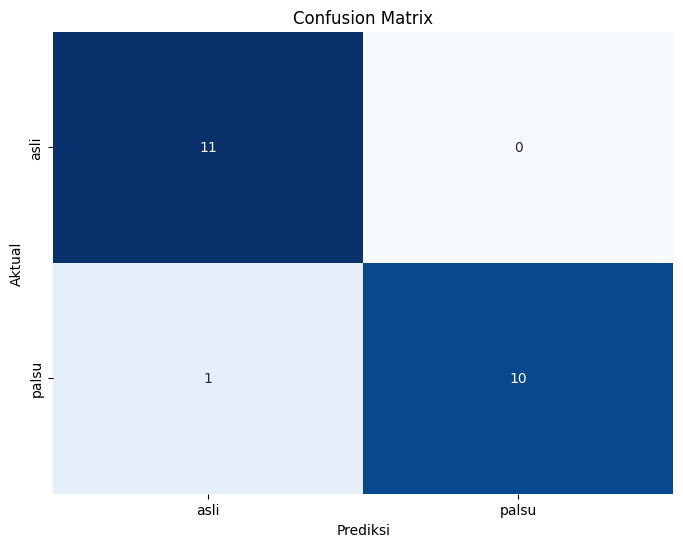

In [ ]:
cm = confusion_matrix(test_generator.classes, pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['asli', 'palsu'],
            yticklabels=['asli', 'palsu'])
plt.title("Confusion Matrix")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.savefig('cm epoch 30.png')
plt.show()

**Simpan Model**

In [ ]:
# Tentukan nama file untuk menyimpan model H5
model_filename = 'model30.h5'

# Simpan model ke dalam file H5
model.save(model_filename)

print(f"Model telah disimpan dalam file: {model_filename}")

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model telah disimpan dalam file: model30.h5


# Prediksi Gambar Baru

In [ ]:
%cd /content/drive/MyDrive/archive

/content/drive/.shortcut-targets-by-id/1hrm502meOfTKXnWAZsJDS6C3RT0YmS5t/Deteksi Rupiah


In [ ]:
from tensorflow.keras.models import load_model

# Tentukan nama file model H5 yang telah disimpan
model_filename = 'model.h5'

# Memuat model
loaded_model = load_model(model_filename)


In [ ]:
from google.colab import files

# Upload gambar
uploaded = files.upload()

# Pastikan nama file gambar sesuai dengan yang diunggah
image_filename = list(uploaded.keys())[0]

IndexError: list index out of range

In [ ]:
import cv2
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Membaca gambar yang diunggah
img = load_img(image_filename, target_size=(224, 224))
img_array = img_to_array(img) / 255.0

# Menambahkan dimensi batch karena model mengharapkan input dalam bentuk batch
img_array = np.expand_dims(img_array, axis=0)

# Menampilkan gambar sebelum prediksi
plt.imshow(img)
plt.title('Input Image')
plt.axis('off')
plt.show()

# Memprediksi kelas gambar
predictions = loaded_model.predict(img_array)

# Mengambil indeks kelas dengan probabilitas tertinggi
predicted_class_index = np.argmax(predictions[0])

# Label mapping
class_mapping = {
    0: 'asli',
    1: 'palsu',
}

# Menampilkan hasil prediksi dengan label
predicted_class_label = class_mapping[predicted_class_index]

# Menampilkan hasil prediksi
print(f'Gambar {image_filename} diprediksi sebagai kelas: {predicted_class_label}')